In [1]:
# Importing the utility with all functions
import importlib
importlib.reload
from CV_utils import *
import numpy as np
import math
import cv2
import itertools as it
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares
from scipy.ndimage import convolve1d, maximum_filter
from typing import Union
from scipy import ndimage
from skimage.transform import hough_line, hough_line_peaks




#### This is a compilation of exercises, their solutions, relevant theory and code for 02504 Computer Vision at DTU.

# **Week 1** - *Homogeneous coordinates and pin hole model*

#### **Exercise 1.1**  - *Consider the following points in 2D. Convert them from homogeneous form to inhomogeneous form*
$$p_1=\begin{bmatrix}1 \\ 2 \\ 1\end{bmatrix}, p_2=\begin{bmatrix}4 \\ 2 \\ 2\end{bmatrix}, p_3=\begin{bmatrix}6 \\ 4 \\ -1\end{bmatrix}, p_4=\begin{bmatrix}5 \\ 3 \\ 0.5\end{bmatrix}$$

Converting them is done by scaling each coordinate by dividing with the third scaling coordinate and removing it, hence:

$$q_1=\begin{bmatrix}1/1 \\ 2/1 \\ \sout{1}\end{bmatrix}=\begin{bmatrix}1 \\ 2\end{bmatrix}, ~~q_2=\begin{bmatrix}2 \\ 1\end{bmatrix}, ~~ q_3=\begin{bmatrix}-6 \\ -4\end{bmatrix}, ~~ q_4=\begin{bmatrix}10 \\ 6\end{bmatrix}$$



#### **Exercise 1.2**  - *Consider the following four points in 3D. What is their corresponding inhomogeneous coordinates $Q_i$?*
$$P_1=\begin{bmatrix}1 \\ 10 \\ -3 \\ 1\end{bmatrix}, \dots, P_4=\begin{bmatrix}-15 \\ 3 \\ 6 \\ 3\end{bmatrix}$$

Similarly to exercise 1.1, but with an added dimension we have:
$$Q_1=\begin{bmatrix}1\\10\\-3\end{bmatrix}, ~~Q_2=\begin{bmatrix}1\\-2\\0.55\end{bmatrix}, ~~Q_3=\begin{bmatrix}0\\0\\-0.1\end{bmatrix}, ~~Q_4=\begin{bmatrix}-5\\1\\2\end{bmatrix}$$



#### **Exercise 1.3**  - *A 2D line is given by $x+2y=3$. Write it in inhomogeneous form, ie. $l^Tp=0$*
We can read the coefficients $a$, $b$ and $c$ directly from the line formulation, hence:

$$l^Tp=\begin{bmatrix}a & b & c\end{bmatrix}\begin{bmatrix}sx \\ sy \\ s\end{bmatrix} \Rightarrow l=\begin{bmatrix}1 \\ 2 \\ -3\end{bmatrix}$$


#### **Exercise 1.4**  - *Given $l$ from 1.3, which of the points $p_i$ are on this line?*
For a point to be on a line it must obey $l^Tp=0$, hence we have:
$$l^Tp_1=\begin{bmatrix}1&2&-3\end{bmatrix}\begin{bmatrix}3\\0\\1\end{bmatrix}=3+0-3=0$$
The other points are omitted due to brevity and that it is a trivial relation.


#### **Exercise 1.5**  - *Given $l_0$ and $l_1$, what is these lines point of intersection $q_1$?*
The intersection of lines can be found a the cross product between them, ie:
$$q_1=l_0\times l_1=\begin{bmatrix}(a_2b_3-a_3b_2)\\(a_3b_1-a_1b_3)\\(a_1b_2-a_2b_1)\end{bmatrix}\\=\begin{bmatrix}1\cdot(-3)-(-1)\cdot1\\-1\cdot(-1)-1\cdot(-3)\\1\cdot1-1\cdot(-1)\end{bmatrix}=\begin{bmatrix}-2\\4\\2\end{bmatrix}$$



#### **Exercise 1.6**  - *Given the matrix $\mathbf{A}\begin{bmatrix}10&0&2 \\ 0&10&-3 \\0&0&1\end{bmatrix}$, what is the result of $Ap=q$, where $p$ and $q$ are 2D points in homogeneous coordinates? Explain what the (non-zero) coefficients of A do to q.*
A is the so-called camera matrix, where $f=10$, $\delta_x = 2$, and $\delta_y = -3$. It projects the point $p$ to the image plane using $f$ and translates the point (to the image coordinate system by moving the origin) using the $\delta$'s. The scaling is applied column-wise to $x$, $y$ and translations, respectively, ie.
$$Ap = [10x+2, 10y-3, 1]$$

Note, if the last diagonal entry in A was 10, then it would not have affected the inhomogeneous coordinates of q. The remaining two non-zero off-diagonal factors are 2D translations, which happen *after* scaling.


#### **Exercise 1.7 & 1.8**  - *Given a line $l$, what is the shortest distance $d$ between it and points $p_i$?*
The shortest distance can be found as:
$$d_1=\frac{|l^Tp_1|}{|p_{1,w}|\sqrt{l_x^2+l_y^2}}=\frac{\bigg|\begin{bmatrix}1/\sqrt{2}\\1/\sqrt{2}\\-1\end{bmatrix}^T\begin{bmatrix}0\\0\\1\end{bmatrix}\bigg|}{\sqrt{1^2}\cdot\sqrt{(1/\sqrt{2})^2+(1/\sqrt{2})^2}}=\frac{\sqrt{(-1)^2}}{1\cdot\sqrt{1}}=1$$

$$d_2=\frac{\sqrt{(\sqrt{2}\cdot\sqrt{\frac{1}{\sqrt{2}}}+\sqrt{2}\cdot\sqrt{\frac{1}{\sqrt{2}}}+1\cdot(-1))^2}}{\sqrt{1^2}\cdot\sqrt{1^2}}=\frac{\sqrt{(1+1-1)^2}}{1}=1$$

$$d_3=\frac{\sqrt{(1+1-4)^2}}{\sqrt{4^2}\cdot\sqrt{1^2}}=\frac{2}{4}=\frac{1}{2}$$
Exercise 1.8 is all the same but with a new line.



#### Programming exercises

#### **Exercise 1.9 & 1.10** - *Load and display and image with OpenCV/Matplotlib*

Current OpenCV version is: 4.7.0


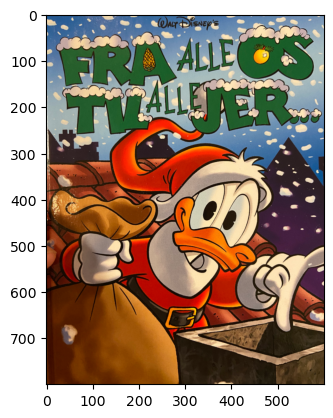

In [2]:
import cv2; import matplotlib.pyplot as plt; 
print(f"Current OpenCV version is: {cv2.__version__}"); 
im = cv2.imread('../02504_CV/data/Donald.png')
# Note OpenCV flips colour scheme. Hence, do below.
plt.imshow(im[:,:,::-1])


#### Pinhole camera helper functions.
This lets us project several 3D points into an image plane. Read the book for relevant theory regarding pinhole cameras.

#### **Exercise 1.11 + 1.12 + 1.13** - *Helper functions*

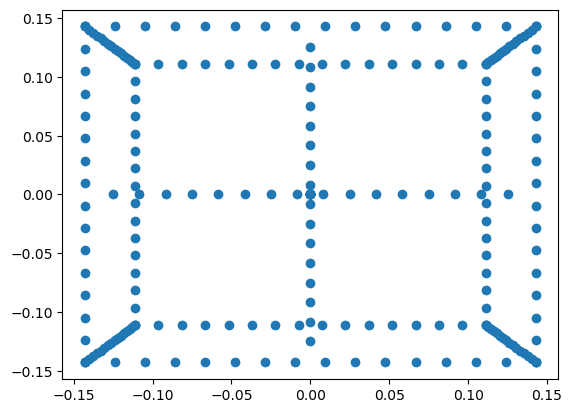

In [3]:
# Test of projectpoints()
K = np.eye(3)
R = np.eye(3)
t = np.array((0, 0, 4))
box = box3d()
box_projected = projectpoints(K, R, t, box)
plt.scatter(*box_projected);

#### **Exercise 1.14** - *$\theta=30^o=\frac{\pi}{6}$ with $R=\begin{bmatrix}\cos(\theta) & 0 & \sin(\theta) \\ 0 & 1 & 0 \\-\sin(\theta) & 0 & \cos(\theta)\end{bmatrix}$ what is the effect?*

The box is rotated by theta horizontally.


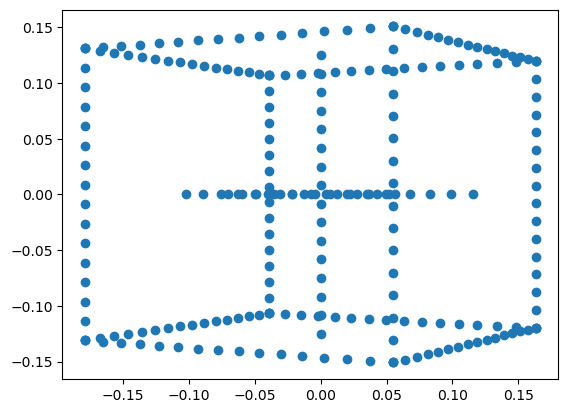

In [4]:
theta = math.pi / 6
R = np.array([
    [math.cos(theta), 0, math.sin(theta)],
    [0, 1, 0],
    [-math.sin(theta), 0, math.cos(theta)]
])

box_projected = projectpoints(K, R, t, box)
plt.scatter(*box_projected);
print("The box is rotated by theta horizontally.")

Changing $R$ primarily means that we are rotating along different axes. Changing $t$ alters the translation of the camera with respect to the object.

# **Week 2** - *Camera model and homographies*
Note that we assume a *modern* camera with square pixels in the following exercises.

#### **Exercise 2.1** 
##### a) *Assume $f=600$, $\alpha=1$, $\beta=0$, and $\delta x=\delta y=400$*. In a traditional camera, what is the resolution in pixels?

$\delta x$, $\delta y$ denote the principal point, i.e., the centre of the image! Thus the resolution is 
$2\delta x \times 2\delta y$. In this case we have $800 \times 800$ pixels.

##### b) Assume $R=I$ and $t=[0, .2, 1.5]^T$. Are all points captured by image sensor? (use `projectpoints()`)

No, inspect the y-axis values. Some points are above 800, ie. are not captured by the sensor. However, it also starts at 200, so subtracting 100 would get us within out 800x800 pixel space.


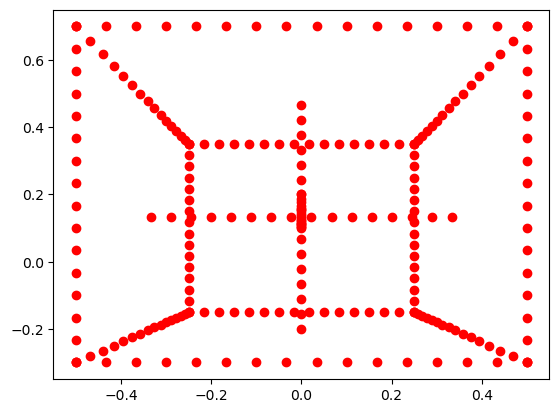

In [5]:
R = np.eye(3); t = np.array([0,.2,1.5]).T;
box_3d = box3d()
box_2d = projectpoints(K, R, t, box_3d)
plt.scatter(box_2d[0,:], box_2d[1,:], color='red')
plt.show()

##### c) *Where does the corner $P_1$ project to?*

Coordinate of projected 3D point P1 to 2D point: [[-0.5]
 [-0.3]]


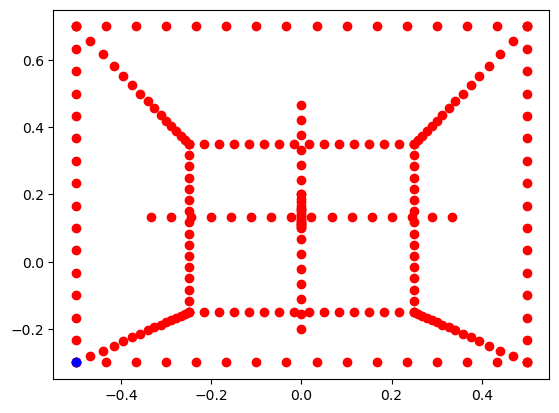

In [6]:
p_3d = np.array([-0.5,-0.5,-0.5]).reshape(-1,1)
p_2d = projectpoints(K, R, t, p_3d)
print(f'Coordinate of projected 3D point P1 to 2D point: {p_2d}')
plt.scatter(box_2d[0,:],box_2d[1,:],color='red')
plt.scatter(p_2d[0],p_2d[1], color='blue')
plt.show()

#### **Exercise 2.2** - *Alter helper function `projectpoints()` to function with distortion from distCoeffs*
##### Furthermore assume that the distortion is $\Delta r(r)=-0.2r^2$
a) What are the distortion coefficients in this case?

They are -0.2 and wil be 0 for $r^k$ when $k>2$ (Read slides if in doubt)

b) Where does $P_1$ project to?

Given below.


c) Are all points now captured by the image sensor?

Yes (Axes a perturbed by code, but source: trust me bro)

Projected point: [[-0.466 ]
 [-0.2796]]


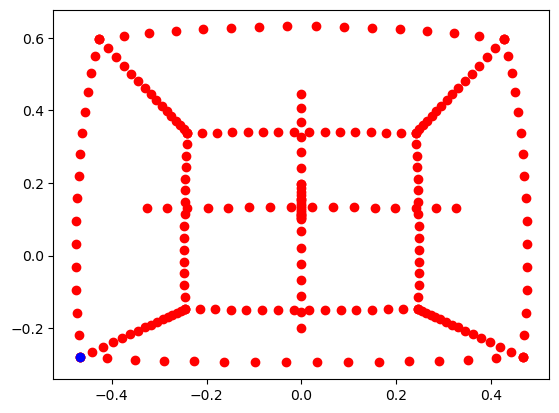

In [7]:
distortion_coeff = np.array([-0.2])
pts_dist = projectpoints_dist(K, R, t, box_3d, distortion_coeff)
p1_dist = projectpoints_dist(K,R,t, p_3d, distortion_coeff)
print(f"Projected point: {p1_dist}")
plt.scatter(pts_dist[0,:], pts_dist[1,:],color='red')
plt.scatter(p1_dist[0],p1_dist[1], color='blue')
plt.show()

**Exercise 2.3** - *Assume $f=0.455732\cdot\texttt{im width}$, and reasonable guess of $\alpha$ and $\beta$ with distortion coefficients $k_i$. What is $\mathbf{K}$?*

In [8]:
im = cv2.imread('../02504_CV/data/gopro_robot.jpg')[:,:,::-1]
im = im.astype(float)/255
#plt.imshow(im)
#plt.show()
# Assumptions from descr.
f = 0.455732*im.shape[1]
dy = im.shape[0]/2
dx = im.shape[1]/2
k = np.array([-0.245031,0.071524,-0.00994978])
K = np.array([[f,0,dx],
              [0,f,dy],
              [0,0,1]])
print(K)

[[875.00544   0.      960.     ]
 [  0.      875.00544 540.     ]
 [  0.        0.        1.     ]]


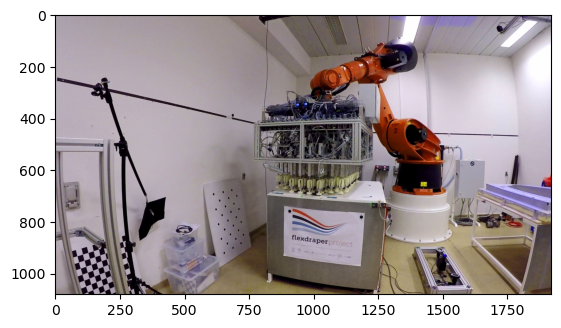

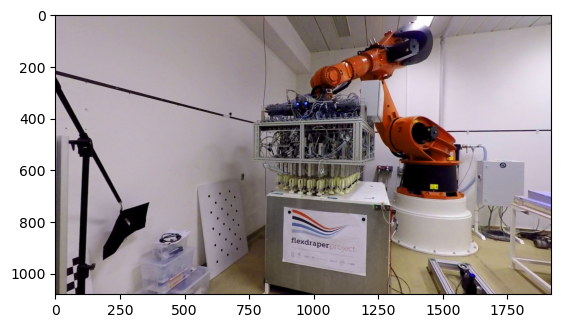

In [9]:
im_undistorted = undistortImage(im, K, k)
plt.imshow(im)
plt.show()
plt.imshow(im_undistorted);

#### **Exercise 2.5** - *Consider points on a plane $p_{2i}$. With homography $\mathbf{H}$, map the points $\mathbf{Hq}_2$*
Converting $p_{2i}$ from inhomogeneous to homogenous, then map via homography $q_{ih}=Hp_{ih}$, then remap to inhomogeneous.

In [10]:
#Column wise point 2D points
points = np.array([ [1, 0, 2, 2],
                    [1, 3, 3, 4] ])
H = np.array([  [-2, 0, 1],
                [1, -2, 0],
                [0,  0, 3]   ])
q2 = PiInv_v(points)
q1 = H @ q2
print("Columns:   q21 \t    | \tq22 \t|   q23        |   q24 |")
np.array([Pi(q1)[:,0], Pi(q1)[:,1], Pi(q1)[:,2], Pi(q1)[:,3]]).T

Columns:   q21 	    | 	q22 	|   q23        |   q24 |


array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ]])

#### **Exercise 2.6** - *implement `hest()`, which takes two sets of 2D points and returns estimated H by linear algorithm. Use 2.5, are they scaled? Why is this fine?*

We should obtain the same H, but multiplied such that $||H||_F=1$

In [11]:
qs = [Pi(q1)[:,0], Pi(q1)[:,1], Pi(q1)[:,2], Pi(q1)[:,3]]
ps = [points[:,0], points[:,1], points[:,2], points[:,3]]
#print(f"qs:{qs}"); print(f"ps:{ps}")
H0 = hest(qs, ps)
#Frobenius norm of original homography H
normH = np.linalg.norm(H)
#Sanity checks
print(f"Original homography (H):\n {H}")
print(f"Scaling factor (Norm of original H):\n {normH}")
print(f"Frobenius norm of H_est (should be 1):\n {round(np.linalg.norm(H0),5)}")
print(f"Scaled H_est by -Frob of original H: \n{np.round(-normH * H0, 2)}")

Original homography (H):
 [[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]
Scaling factor (Norm of original H):
 4.358898943540674
Frobenius norm of H_est (should be 1):
 1.0
Scaled H_est by -Frob of original H: 
[[-2.  0.  1.]
 [ 1. -2. -0.]
 [-0.  0.  3.]]


#### **Exercise 2.7** 

In [12]:
qtest = np.hstack((q1, q2))
T, Tinv = normalize2d(Pi(qtest))
pnorm = Pi(T @ qtest)
pnorm.mean(1), pnorm.std(1) 

(array([0., 0.]), array([1., 1.]))

#### **Exercise 2.8**

# **Week 3** - *Multi-view Geometry*
Set up two cameras, both with the internal parameters:

First camera **Cam1** has the rotation as $R1 = I$ and the translation to zero, $t1 = 0$. For the second camera **Cam2** use the rotation given by the $R$ function and translation $t$:

$$R_2=\mathcal{R}(0.7, -0.5, 0.8), ~~~~~t_2=\begin{bmatrix}0.2\\2\\1\end{bmatrix}$$

The rotation can be constructed in Python using Rotation module from scipy as follows: 
```python
    from scipy.spatial.transform import Rotation
    R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
```

#### **Exercise 3.1** - *Consider 3D point $Q$. Find the projections in **Cam1** and **Cam2**, ie. $q_1$ and $q_2$*

In [13]:
from scipy.spatial.transform import Rotation
K = np.array([[1000,0,300],[0,1000,200],[0,0,1]])
R1 = np.eye(3)
t1 = np.zeros(3).reshape(-1,1)
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.array([0.2,2,1]).reshape(-1,1)

Q = np.array([1,0.5,4,1]).reshape(-1,1)
q1 = projectpoints(K,R1,t1,Pi(Q))
q2 = projectpoints(K,R2,t2,Pi(Q))
print(f"q1: {q1}"); print(f"\nq2: {q2}")

q1: [[550.]
 [325.]]

q2: [[582.47256835]
 [185.98985776]]


#### **Exercise 3.2** - *Implement `CrossOp()`, which takes 3D vector and returns the crossproduct matrix of that vector.*

In [14]:
np.array([np.zeros(3)])

array([[0., 0., 0.]])

In [15]:
def CrossOp(p):
    p = p.reshape(len(p))
    x = p[0]
    y = p[1]
    z = p[2]
    return np.array([[0,-z,y],[z,0,-x],[-y,x,0]])
try:
    assert((CrossOp(t2)@t2).all()==0)
    assert(np.cross(t2.reshape(len(t2)),t2.reshape(len(t2))).all()==0)
except:
    print('WARNING: CrossOp() does not work as intended.')

#### **Exercise 3.3** - *Compute the fundamental matrix $F$ of the two cameras*

In [16]:
E = CrossOp(t2)@R2
F = np.linalg.inv(K).T@E@np.linalg.inv(K)
print('Fundemantal matrix, F: \n', F)

Fundemantal matrix, F: 
 [[ 3.29311881e-07  8.19396327e-07  1.79162592e-03]
 [ 5.15532551e-07 -8.76915984e-07  9.31426656e-05]
 [-1.29882755e-03  1.51951700e-03 -1.10072682e+00]]


#### **Exercise 3.4** - *What is the epipolar line $l$ of $q_1$ in **Cam2**?*

**Note**: $l$ inadverdently depends of the scale of $q_1$. Hence, we rescale it by the possible solutions (relevant for exam). This should give an answer option when correct: 

In [17]:
l = F@PiInv(q1)
# Trick to find correct solution
l_first_entry = l[0]
answer_option_first_entry = 8.956e-3
scale = answer_option_first_entry/l_first_entry
print("Rescaled epipolar line: \n", l*scale)

Rescaled epipolar line: 
 [[ 8.95600000e-03]
 [ 3.66743100e-04]
 [-5.28483482e+00]]


#### **Exercise 3.5** - *Is $q_2$ located on epipolar line $l$? Explain why this **must** be so!*
Recall for a point to be on a line it must obey $l^Tq=0$

Since $q_2$ and $l$ are derived from the same 3D point $Q$, which yields a single epipolar plane, in turn yielding a single line in each camera! Projections of 3D point must lie on the epipolar lines.


In [18]:
np.round((l*scale).T@PiInv(q2),4) #You can do this with the scaled line
np.round(l.T@PiInv(q2),4) #or the non-scaled line :D

array([[0.]])

#### **Exercise 3.6** - *Assume local coordinate systems in **Cam1** and **Cam2**, which are different from the world coordinate system. Let $Q$ and $\tilde{Q}$ denote the **same** 3D point in world space and in the frame of camera one, ie.*: 
$$\tilde{Q}= \begin{bmatrix}R_1 & t_1 \\ 0 & 1\end{bmatrix}Q$$

Show analytically that $$\tilde{Q}= \begin{bmatrix}R_1^T & -R_1^Tt_1 \\ 0 & 1\end{bmatrix}$$

Putting Eq 14 into Eq 13 shows they are inverses of each other:

$$\tilde{Q}= \begin{bmatrix}R_1 & t_1 \\ 0 & 1\end{bmatrix}\begin{bmatrix}R_1^T & -R_1^Tt_1 \\ 0 & 1\end{bmatrix}\tilde{Q}=\begin{bmatrix}I & 0 \\ 0 & 1\end{bmatrix}\tilde{Q}$$


#### **Exercise 3.7** - *See solutions from EX03.pdf*

#### **Exercise 3.8** - *Load data and compute fundamental matrix $F$ between **Cam1** and **Cam2** *

In [19]:
im_object = np.load('../02504_CV/data/TwoImageData.npy', allow_pickle=True).item() 
#Object with all the necessary matrices in it (as well as images)
R2 = im_object['R2']
t2 = im_object['t2']
K = im_object['K']
E = CrossOp(t2)@R2
F = np.linalg.inv(K).T@E@np.linalg.inv(K)
F

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

#### **Exercise 3.9** - *Show both images, and have interactive click point in image 1 and display corresponding epipolar line in other image.*

In [20]:
def DrawEpipolarLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    plt.plot(*np.array(P).T, 'r')

In [21]:
%matplotlib qt
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_object['im1'])
ax[1].imshow(im_object['im2'])
def PiInv(p, scale=1):
    p = np.vstack((p,scale*np.ones(p.shape[1]).reshape(1,-1)))
    return scale*p
point = PiInv(np.array(plt.ginput(1)).reshape(-1,1))
l = F@point
DrawEpipolarLine(l, im_object['im2'].shape)
plt.show()
#Dont confuse l and l_im hahaha

#### **Exercise 3.10** - *Do the same as 3.9, but the other way around, ie. for image two --> epipolar line image 1*

In [22]:
%matplotlib qt
fig, ax = plt.subplots(1,2)
ax[0].imshow(im_object['im2'])
ax[1].imshow(im_object['im1'])
point = PiInv(np.array(plt.ginput(1)).reshape(-1,1))
l = F@point
DrawEpipolarLine(l, im_object['im1'].shape)
plt.show()

#### **Exercise 3.11** -  *Triangulate a single 3D point seen by $n$ cameras*

((8, 3, 4), (2, 8))

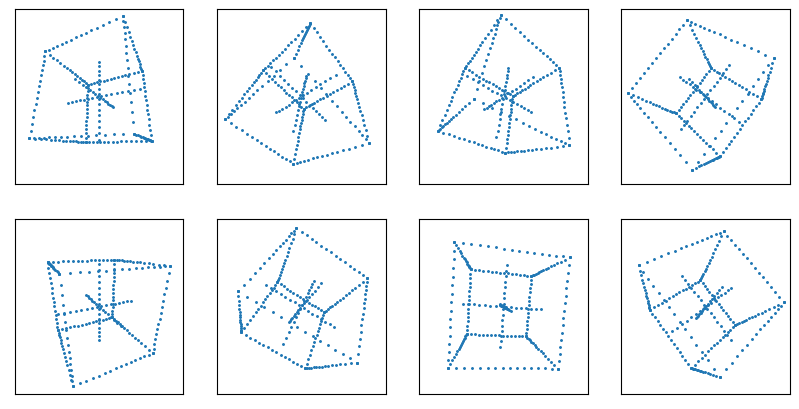

In [23]:
from scipy.spatial.transform import Rotation
f, alpha, beta, deltax, deltay = 600, 1, 0, 400, 400
K = np.array([
    [f, beta*f, deltax],
    [0, alpha*f, deltay],
    [0, 0, 1]
])

box = box3d()

# Choose a point in the box
point = 100
%matplotlib inline
Ps = []
qs = []
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
for ax in axs.ravel():
    R = Rotation.from_euler('xyz', np.random.uniform(-np.pi/2, np.pi/2, size=3)).as_matrix()
    t = np.array([0, 0, 1.6])
    box_projected = ProjectPoints_(K, R, t, box)
    
    Ps.append(K @ np.hstack((R, t[:, np.newaxis])))
    qs.append(box_projected[:, point:point+1])
    
    ax.scatter(*box_projected, s=1.2)
    ax.set_xlim(0, 2*deltax), ax.set_ylim(2*deltay, 0)
    ax.set_xticks([]), ax.set_yticks([])
Ps = np.stack(Ps)
qs = np.hstack(qs)
Ps.shape, qs.shape

In [24]:
Q_true = box[:, point]
Q = triangulate(qs, Ps)
Q_true, Q

(array([-0.23333333, -0.5       ,  0.5       ]),
 array([-0.23333333, -0.5       ,  0.5       ]))

# **Week 4** - *Camera Calibration*

These exercises will take you through:
Direct linear transform (DLT), linear algorithm for camera calibration and
checkerboard calibration, and bundle adjustment from Zhang (2000). You should be able to perform camera calibration using both methods.

Consider 3D points of the form $Q_{ijk}=\begin{bmatrix}i\\ j\\ k\end{bmatrix}$ with binary entries (0,1). Consider cameras with $f=1000$ and resolution $1920\times 1080$. The camera is transformed such that $R=\begin{bmatrix}\sqrt{1/2} & \sqrt{1/2} & 0\\ \sqrt{1/2} & \sqrt{1/2} &0 \\ 0&0&1\end{bmatrix}$ and $t=\begin{bmatrix}0\\ 0\\ 10\end{bmatrix}$

#### **Exercise 4.1** - *Find the projection matrix $\mathcal{P}$ and the projections $q$*

In [25]:
f, deltax, deltay = 1e3, 960, 540
vals = (0, 1)

Q = [np.array([i, j, k]) 
    for i in vals 
    for j in vals 
    for k in vals]
Q = PiInv(np.array(Q).T)

K = np.array([  [f, 0, deltax],
                [0, f, deltay],
                [0, 0, 1] ])
R = np.array([
        [math.sqrt(.5), -math.sqrt(.5), 0],
        [math.sqrt(.5), math.sqrt(.5), 0],
        [0, 0, 1]
])
t = np.array([0, 0, 10])


P = K @ np.hstack((R, t[:, np.newaxis]))
q = P @ Q
print("Projections q: \n", Pi(q)[:, :3])
print("P: \n", P)

Projections q: 
 [[960.         960.         889.28932188]
 [540.         540.         610.71067812]]
P: 
 [[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]


#### **Exercise 4.2** - *Write a function pest that uses $Q$ and $q$ to estimate $\mathcal{P}$ with the DLT. Do not normalize your points to begin with. Use the estimated projection matrix $P_{est}$ to project the points $Q$, giving you the re-projected points $q_{est}$*

- What is the overall reprojection error $\sqrt{\sum\frac{1}{n}||q_{est}-q||^2_2}$ (RMSE)? 

- Does normalizing your points change the results?

The projection matrix and the reprojections are identical to the original within machine precision.

The error is approximately $10^{-11}$ unnormalized and $10^{-14}$ normalized.



<p style="color:red">There is a discrepancy with Felix/Rune's code and when I run it. I get 2.33e-10, they get 1.27e-10.</p>

In [26]:
def pest(
      Q: np.array,
      q: np.array,
      normalize=True
    ):
    if normalize:
        TQ, TQinv = normalize3d(Pi(Q))
        Tq, Tqinv = normalize2d(Pi(q))
        Q, q = TQ @ Q, Tq @ q
    B = np.vstack([
        np.kron(Qi, cross_op(qi / qi[-1]))
        for Qi, qi in zip(Q.T, q.T)
    ])
    u, s, v = np.linalg.svd(B)
    
    P = v[-1].reshape(4, 3).T
    return Tqinv @ P @ TQ if normalize else P

Pest = pest(Q, q, normalize=False)
qest = Pest @ Q
RMSE = np.sqrt(
    np.mean(np.linalg.norm(Pi(qest) - Pi(q), axis=0)**2)
)
print(f"Not normalized: {RMSE}")
Pest = pest(Q, q, normalize=True)
qest = Pest @ Q
RMSE = np.sqrt(
    np.mean(np.linalg.norm(Pi(qest) - Pi(q), axis=0)**2)
)
print(f"Normalized: {RMSE}")

Not normalized: 2.329131949179513e-10
Normalized: 1.2710574864626038e-13


#### **Exercise 4.3** - *Checkerboard calibration 1*

In [27]:
def checkerboard_points(n, m):
    return np.vstack([np.array([i - (n-1)/2, j - (m-1)/2, 0])  
                      for j in range(m)
                      for i in range(n)]).T

#### **Exercise 4.4** - *Let $Q_{\Omega}$ define a set of corners on the checkerboard. Define three sets of checkerboard points as:* 
$$Q_a=\mathcal{R}(\frac{\pi}{10},0,0)Q_{\Omega}, \\ Q_b=\mathcal{R}(,0,0)Q_{\Omega}, \\Q_c=\mathcal{R}(-\frac{\pi}{10},0,0)Q_{\Omega}$$

#### *Via projection matrix in 4.1, project all points to the image plane obtaining $q_a$, $q_b$ and $q_c$.*

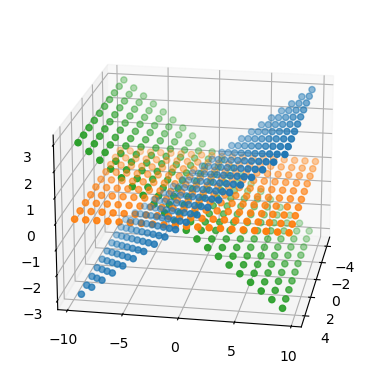

In [28]:
# Sanity check of Rotation.
n, m = 10, 20
Qomega = checkerboard_points(n, m)
Ra = Rotation.from_euler('xyz', [math.pi/10, 0, 0]).as_matrix()
Rb = np.eye(3)
Rc = Rotation.from_euler('xyz', [-math.pi/10, 0, 0]).as_matrix()

Qa = Ra @ Qomega
Qb = Rb @ Qomega
Qc = Rc @ Qomega

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*Qa)
ax.scatter(*Qb)
ax.scatter(*Qc)
ax.view_init(20, 10)

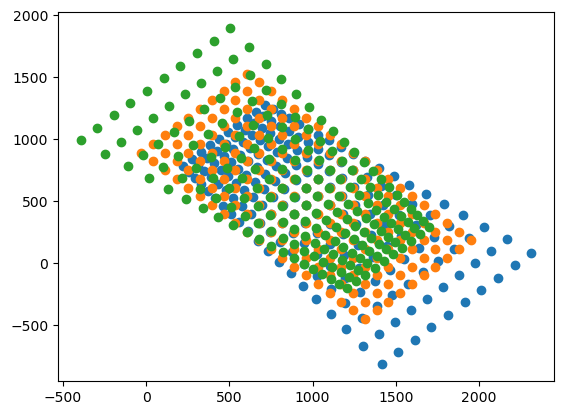

In [29]:
qa, qb, qc = P @ PiInv(Qa), P @ PiInv(Qb), P @ PiInv(Qc)

fig, ax = plt.subplots()
ax.scatter(*Pi(qa))
ax.scatter(*Pi(qb))
ax.scatter(*Pi(qc));

#### **Exercise 4.5** - *Zhang's method implementation 1*

In [30]:
import importlib
importlib.reload
from CV_utils import *
import numpy as np
import math
import cv2
import itertools as it
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

In [31]:
qs = np.array([qa, qb, qc])
Hs = estimateHomographies(Qomega, qs)

# Construct Q tilde.
Q_tilde = Qomega.copy()
Q_tilde[-1] = 1

for qi, Hi in zip(qs, Hs):
    qi_est = Hi @ Q_tilde
    print(np.linalg.norm(Pi(qi) - Pi(qi_est), axis=0).mean())

3.2771097687201215e-13
2.2044877689435865e-13
3.0832159540880066e-13


#### **Exercise 4.6** - *Zhang's method implementation 2*

In [32]:
def estimate_b(Hs):

    def get_v(H: np.array, alpha: int, beta: int) -> np.array:
        v = np.array([
            H[0, alpha] * H[0, beta], 
            H[0, alpha] * H[1, beta] + H[1, alpha] * H[0, beta],
            H[1, alpha] * H[1, beta],
            H[2, alpha] * H[0, beta] + H[0, alpha] * H[2, beta],
            H[2, alpha] * H[1, beta] + H[1, alpha] * H[2, beta],
            H[2, alpha] * H[2, beta]
        ])
        return v
    
    V = np.vstack([np.array([get_v(H, 0, 1), get_v(H, 0, 0) - get_v(H, 1, 1)]) for H in Hs])

    u, s, v = np.linalg.svd(V)
    b = v[-1]
    return b / np.linalg.norm(b)

Kinv = np.linalg.inv(K)
Btrue = Kinv.T @ Kinv
btrue = np.array([Btrue[0, 0], Btrue[0, 1], Btrue[1, 1],
                  Btrue[0, 2], Btrue[1, 2], Btrue[2, 2]])
btrue

array([ 1.0000e-06,  0.0000e+00,  1.0000e-06, -9.6000e-04, -5.4000e-04,
        2.2132e+00])

In [33]:
b = -estimate_b(Hs) #Very weird - we get different signs...
#So we add a - in front to make them equal. Play around during exam..
b

array([ 4.51834392e-07,  1.08154846e-22,  4.51834392e-07, -4.33761016e-04,
       -2.43990572e-04,  9.99999876e-01])

In [34]:
# Lets compare
np.mean((b / np.linalg.norm(b)) - (btrue / np.linalg.norm(btrue)))

2.8429463547007227e-19

#### **Exercise 4.7** - *Zhang's Method Implementation 3, estimate Intrinsics*

Takes a list of homographies H and returns a camera matrix K. Use estimate_b from last exercise.

In [35]:
def estimateIntrinsics(Hs):
    """Takes the output of estimateHomographies."""
    # b = [B11 B12 B22 B13 B23 B33]
    b = estimate_b(Hs)
    
    # Use Zhang et al appendix B
    deltay = (b[1] * b[3] - b[0] * b[4]) / (b[0] * b[2] - b[1]**2)
    lambda_ = b[5] - (b[3]**2 + deltay * (b[1] * b[3] - b[0] * b[4])) / b[0]
    f = np.sqrt(lambda_ / b[0])
    alphaf = np.sqrt(lambda_ * b[0] / (b[0] * b[2] - b[1]**2))
    betaf = - b[1] * f**2 * alphaf / lambda_
    deltax = betaf * deltay / alphaf - b[3] * f**2 / lambda_
    alpha = alphaf / f
    beta = betaf / f

    K = np.array([
        [f, beta*f, deltax],
        [0, alpha*f, deltay],
        [0, 0, 1]
    ])
    return K

K_est = estimateIntrinsics(Hs)

np.linalg.norm(K - K_est) # Good enough!

4.301260271192088e-12

#### **Exercise 4.8** - *Zhang's Method Implementation 4, estimating Extrensics*

Takes camera matrix K and homographies H and returns rotations R and translations t of each checkerboard.

In [36]:
def estimateExtrinsics(
        K: np.array, 
        Hs: np.array
    ):
    
    def estimateRt(
            H: np.array, 
            Kinv: np.array
        ):
        lambdai = (np.linalg.norm(Kinv @ H[:, 0]) + np.linalg.norm(Kinv @ H[:, 1])) / 2
        lambdai_inv = 1 / lambdai
        t = lambdai_inv * Kinv @ H[:, 2]
        
        # Correct for flipped solutions, i.e., behind the camera.
        if t[-1] < -1e-7:
            return estimateRt(-H, Kinv)
        else:
            r0 = lambdai_inv * Kinv @ H[:, 0]
            r1 = lambdai_inv * Kinv @ H[:, 1]
            r2 = np.cross(r0, r1)
            R = np.array([r0, r1, r2]).T
        return R, t

    Kinv = np.linalg.inv(K)
    Rs, ts = list(), list()
    for H in Hs:
        R, t = estimateRt(H, Kinv)
        Rs.append(R)
        ts.append(t)
    
    return Rs, ts

def calibratecamera(
        qs: np.array,
        Q: np.array
    ):
    """qs is a list of homogenous points and 
    Q is a 3xn array 3D imhomogenous points."""
    Hs = estimateHomographies(Q, qs)
    K = estimateIntrinsics(Hs)
    Rs, ts = estimateExtrinsics(K, Hs)
    return K, Rs, ts

Rs, ts = estimateExtrinsics(K_est, Hs)

for Ri, Rj, ti in zip(Rs, (Ra, Rb, Rc), ts):
    print((R.T @ Ri).round(3))
    print(Rj.round(3))
    print(ti.round(3))
    print('\n')


[[ 1.     0.    -0.   ]
 [-0.     0.951 -0.309]
 [ 0.     0.309  0.951]]
[[ 1.     0.     0.   ]
 [ 0.     0.951 -0.309]
 [ 0.     0.309  0.951]]
[ 0. -0. 10.]


[[ 1.  0.  0.]
 [-0.  1.  0.]
 [-0. -0.  1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[ 0. -0. 10.]


[[ 1.     0.    -0.   ]
 [ 0.     0.951  0.309]
 [ 0.    -0.309  0.951]]
[[ 1.    -0.     0.   ]
 [ 0.     0.951  0.309]
 [-0.    -0.309  0.951]]
[ 0. -0. 10.]




In [37]:
print('Camera matrix estimate vs. Ground-truth:')
K_est, Rs, ts = calibratecamera(qs, Qomega)
print(K_est.round(2)); print(K)
q_ests = [ProjectPoints_(K_est, R, t, Qomega) for R, t in zip(Rs, ts)]
RMSEs = [np.sqrt(np.mean(np.linalg.norm(q_est - Pi(q), axis=0)**2))
        for q_est, q in zip(q_ests, qs)]
print(f'RMSE error of projected points q_est vs q: \n{np.round(RMSEs, 10)}')


Camera matrix estimate vs. Ground-truth:
[[1000.   -0.  960.]
 [   0. 1000.  540.]
 [   0.    0.    1.]]
[[1000.    0.  960.]
 [   0. 1000.  540.]
 [   0.    0.    1.]]
RMSE error of projected points q_est vs q: 
[0. 0. 0.]


# **Week 5** - *Nonlinear optimization and camera calibration*

In this week we implement non-linear triangulation and perform calibration on checkerboards in real life with OpenCV.

We have two cameras where $R_1=R_2=I$, $t_1=[0~~1~~0]^T$, $t_2=[0~~0~~20]^T$, and $K_1=K_2=\begin{bmatrix}700&0&600\\0&700&400\\0&0&1\end{bmatrix}$.

The cameras both observe the same point in 3D called $Q=[1~~1~~0]^T$

#### **Exercise 5.1** - *What are the projection matrices $P_1$ and $P_2$? What is the projection of $Q$ for each camera, ie. $q_1$ and $q_2$?*

In [38]:
#Declare known variables
R1, R2 = np.eye(3), np.eye(3)
t1, t2 = np.array([0, 0, 1]), np.array([0, 0, 20])

K1 = np.array([
    [700, 0, 600],
    [0, 700, 400],
    [0, 0, 1]
])
K2 = np.array([
    [700, 0, 600],
    [0, 700, 400],
    [0, 0, 1]
])
Q = np.array([1, 1, 0])

In [39]:
P1 = K1 @ np.hstack((R1, t1[:, np.newaxis]))
P2 = K2 @ np.hstack((R2, t2[:, np.newaxis]))
q1, q2 = Pi(P1 @ PiInv(Q)), Pi(P2 @ PiInv(Q))
print(f"q1: {q1}"); print(f"q2: {q2}")

q1: [1300. 1100.]
q2: [635. 435.]


#### **Exercise 5.2** - *To simulate noise in point detection, we add errors to the projections $\tilde{q}_i=q_i+[1~~-1]^T$. Triangulate $\tilde{Q}$ from $\tilde{q}_i$ and $P_i$. What is the reprojection error wrt. $\tilde{q}_i$? Is this expected (recall week 3)? How far is $\tilde{Q}$ from $Q$?*

- We expect linear algorithm to place larger weight on the error of camera 2 than camera 1, as it has a larger $s$-value. Therefore, camera 2 having the lowest reprojection error is expected!

In [40]:
Qarr = np.hstack([
    (q1 + np.array([1, -1]))[:, np.newaxis], (q2 + np.array([1, -1]))[:, np.newaxis]
])
P = np.stack((P1, P2))
Qest = triangulate(Qarr, P)
q1est, q2est = Pi(P1 @ PiInv(Qest)), Pi(P2 @ PiInv(Qest))
print(f"q1_est: {q1est}"); print(f"q2_est: {q2est}");
print(f"Q_est: {Qest}\n")
q1err, q2err = np.linalg.norm(q1 - q1est), np.linalg.norm(q2 - q2est)
Qerr = np.linalg.norm(Q - Qest)
print(f"q1_err: {q1err}"); print(f"q2_err: {q2err}");
print(f"Q_err: {Qerr}")

q1_est: [1310.48950027 1089.4923513 ]
q2_est: [635.53411968 434.4839772 ]
Q_est: [1.01527507e+00 9.85270570e-01 2.85786810e-04]

q1_err: 14.847231966697855
q2_err: 0.7426731182709606
Q_err: 0.021221817353380967


#### **Exercise 5.4** - *Use your `triangulate_nonlin` with $\tilde{q}_i$ and $P_i$. The non-linearly estimated point is $\hat{Q}$. What is the reprojection error from cam1 $\rightarrow$ cam2? How far is it from $Q$? Is it an improvement from linear triangulation?

- We see this is approximately 10 times closer to the true position.

In [41]:
Qest_nonlin = triangulate_nonlin(Qarr, P)
print(f"Q_hat: {Qest_nonlin.round(5)}")
print(f"Q_err: {np.linalg.norm(Q - Qest_nonlin)}")

Q_hat: [1.00154e+00 9.98550e-01 4.00000e-05]
Q_err: 0.0021174153346841663


#### **Exercise 5.6+7** - *Load checkerboard pictures from different angles and detect them using cv2*

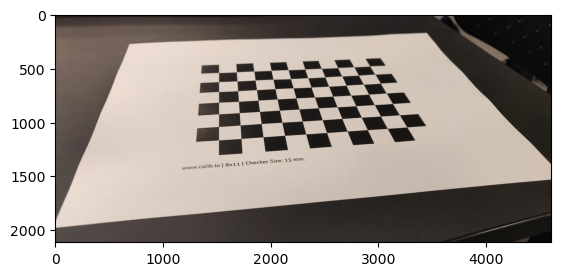

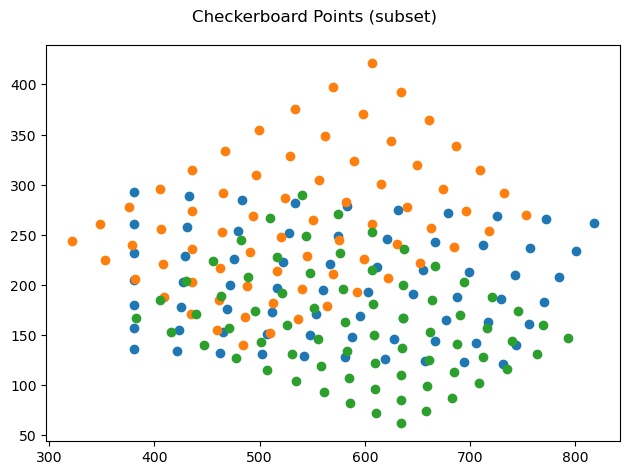

In [42]:
checkers_dir = 'data/checkers_week5'
import os
files = os.listdir(checkers_dir)
ims = [cv2.imread(os.path.join(checkers_dir, file)) 
           for file in files]
plt.imshow(ims[0][:,:,::-1]);
# Check images have same shape. Else discard violaters.
shapes = np.array([im.shape for im in ims])
np.all([shape == shapes[0] for shape in shapes])
# Resize to smaller resolution, map them to grayscale
ims = [cv2.resize(im, None, fx=0.25, fy=0.25) for im in ims]
ims_gray = [cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) for im in ims]
# Find corners via cv2
n, m = 10, 7
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
checkers_size = (n, m)

corners = [cv2.findChessboardCorners(im, checkers_size) 
           for im in ims_gray]
corners = [(i, r, cv2.cornerSubPix(im,c, (11,11), (-1,-1), criteria))
           for i, ((r, c), im) in enumerate(zip(corners, ims_gray)) if r]
ims_filtered = [ims[i] for i, _, _ in corners]
for (i, r, c) in corners:
    im = ims[i].copy()
    cv2.drawChessboardCorners(im, checkers_size, c, r)
    cv2.imshow('img', im)
    cv2.waitKey(500)
cv2.destroyAllWindows()

def checkerboard_points(n, m):
    return np.vstack([np.array([i - (n-1)/2, j - (m-1)/2, 0])  
                      for j in range(m)
                      for i in range(n)]).T

Q = checkerboard_points(n, m)
qs = [PiInv(q.squeeze().T) for i, r, q in corners]

fig, ax = plt.subplots(tight_layout=True)
fig.suptitle('Checkerboard Points (subset)')
for q in qs[:3]:
    ax.scatter(*q[:2])

#### **Exercise 5.8** - *Calibrating camera, ie. find camera matrix $K$*

In [43]:
K, Rs, ts = calibratecamera(qs, Q)
print(f"Camera matrix estimate from calibration, K:\n {K.round()}")
print(f"Principal point:\n {np.array(ims[0].shape[1::-1])/2}")
# Seems to match centor of images. Nice.

Camera matrix estimate from calibration, K:
 [[944. -21. 559.]
 [  0. 878. 172.]
 [  0.   0.   1.]]
Principal point:
 [576. 264.]


#### **Exercise 5.9** - *Reproject checkerboard corners to images. Compute reprojection error for each frame, and show the one with highest error.*

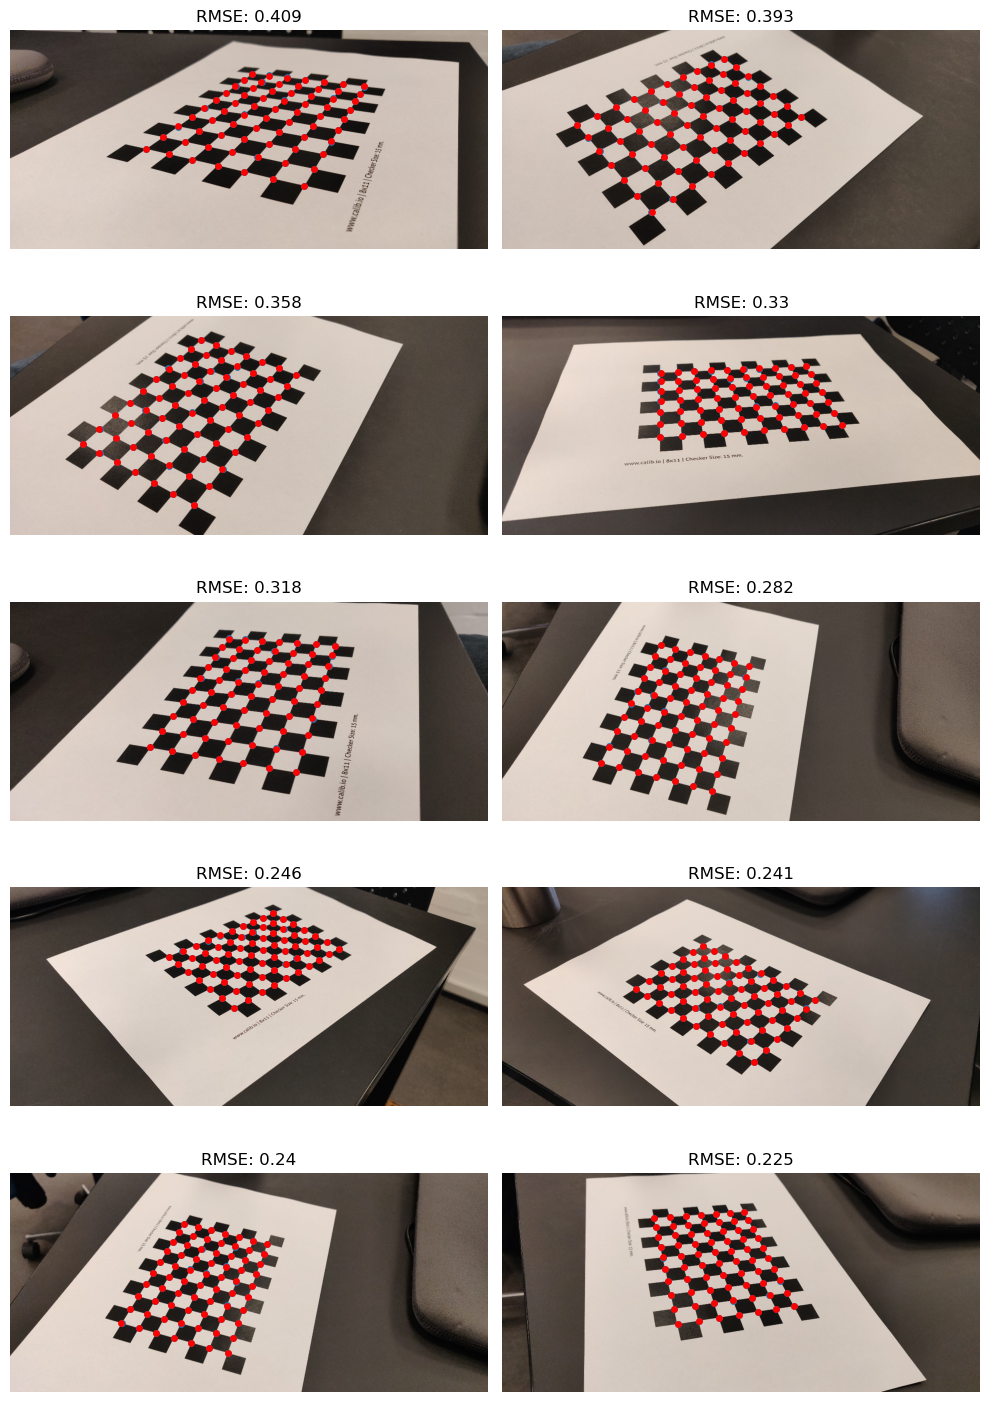

In [44]:
q_ests = [ProjectPoints_(K, R, t, Q) for R, t in zip(Rs, ts)]
RMSEs = [np.sqrt(np.mean(np.linalg.norm(q_est - Pi(q), axis=0)**2))
        for q_est, q in zip(q_ests, qs)]
max_indices = np.argsort(RMSEs)[::-1][:10]

fig, axs = plt.subplots(5, 2, figsize=(10, 15), tight_layout=True)
axs = np.asarray(axs).ravel()
for i, ax in zip(max_indices, axs):
    R, t, q, q_est, im = Rs[i], ts[i], qs[i], q_ests[i], ims_filtered[i]
    RMSE = RMSEs[i]
    ax.imshow(im[:, :, ::-1])
    ax.scatter(*q[:2], s=15)
    ax.scatter(*q_est, c='r', s=15)
    ax.axis('off'); RMSE_ = round(RMSE, 3)
    ax.set_title("RMSE: " + str(RMSE_)) #In pixels

#### **Exercise 5.10** - *Create a new set of points $Q$ and project them with $R$ and $t$ and visualize result. Should be a 3D 2x2 box*

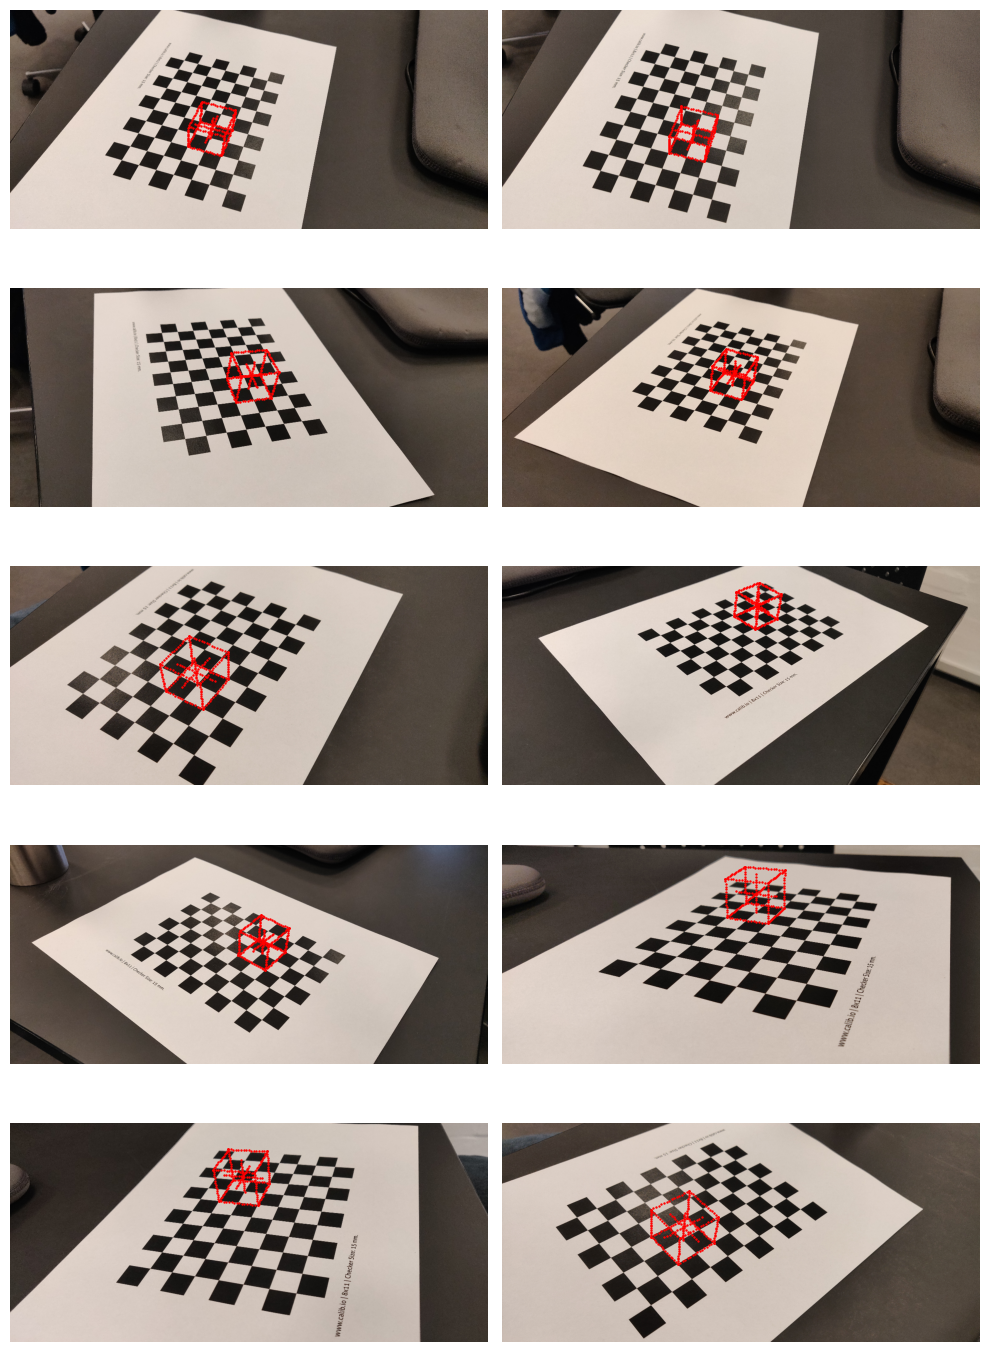

In [45]:
indices = np.random.choice(len(qs), size=10, replace=False)
Qbox = 2 * box3d() + 1
Qbox = Qbox + np.array((.5, 0, 0))[:, np.newaxis]
Qbox = Rotation.from_euler('xyz', [np.pi, 0, 0]).as_matrix() @ Qbox

fig, axs = plt.subplots(5, 2, figsize=(10, 15), tight_layout=True)
axs = np.asarray(axs).ravel()
for i, ax in zip(indices, axs):
    R, t, im = Rs[i], ts[i], ims_filtered[i]
    qbox = ProjectPoints_(K, R, t,Qbox)
    # qbox = (R @ (K @ Qbox) + t[:, np.newaxis])
    ax.imshow(im[:, :, ::-1])
    # ax.scatter(*qs[i][:2], s=12)
    ax.scatter(*qbox, c='r', s=.5)
    ax.axis('off')

# **Week 6** - *Simple features*
The learning objective is feature extraction, which includes Harris corner detection and the Canny edge detector. These are often used in real world applications!

#### **Exercise 6.1** - *Create a 1D gaussian kernel function. Normalize it such that it sums to 1*

Sum to one sanity check: 1.0


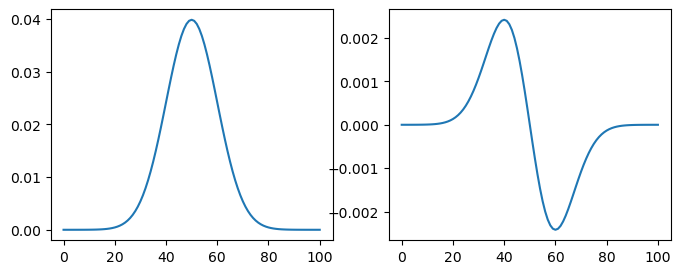

In [46]:
g, gd = gaussian1DKernel(10)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))
ax0.plot(g)
ax1.plot(gd);
print(f"Sum to one sanity check: {np.round(g.sum())}")

#### **Exercise 6.2** - *Smooth an image with `gaussianSmoothing()`.*

- What happens if $\sigma=0$? (It's a Gaussian width, used in calculation derivatives)

- What should the function return if it supported that?

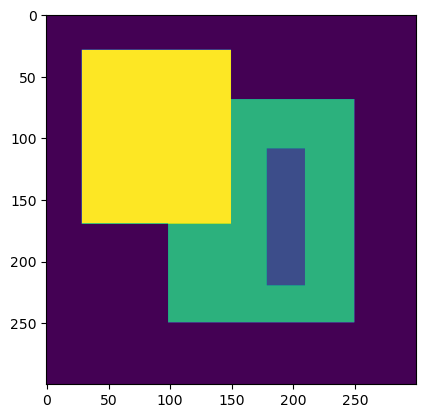

In [47]:
im = cv2.imread(f'data/TestIm1.png', cv2.IMREAD_GRAYSCALE).astype(float)
im -= im.min()
im /= im.max()
plt.imshow(im);

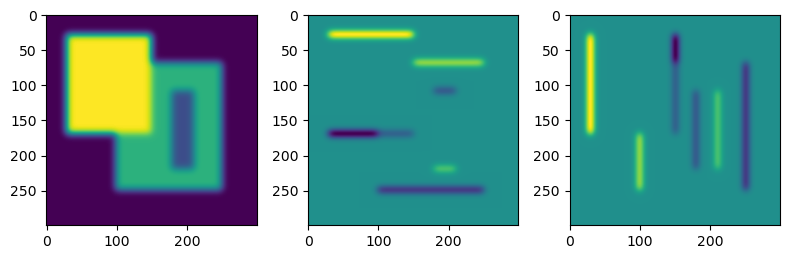

In [48]:
sigma = 5
I, Ix, Iy = gaussianSmoothing(im, sigma)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4), tight_layout=True)
ax0.imshow(I)
ax1.imshow(Ix)
ax2.imshow(Iy);

#### **Exercise 6.3** - *Create `smoothingHessian()`, which convolves with a new Gaussian kernel with width $\epsilon$.*

- $\epsilon$ calculates the Hessian, while $\sigma$ calculates the derivatives. Do we need to use both?


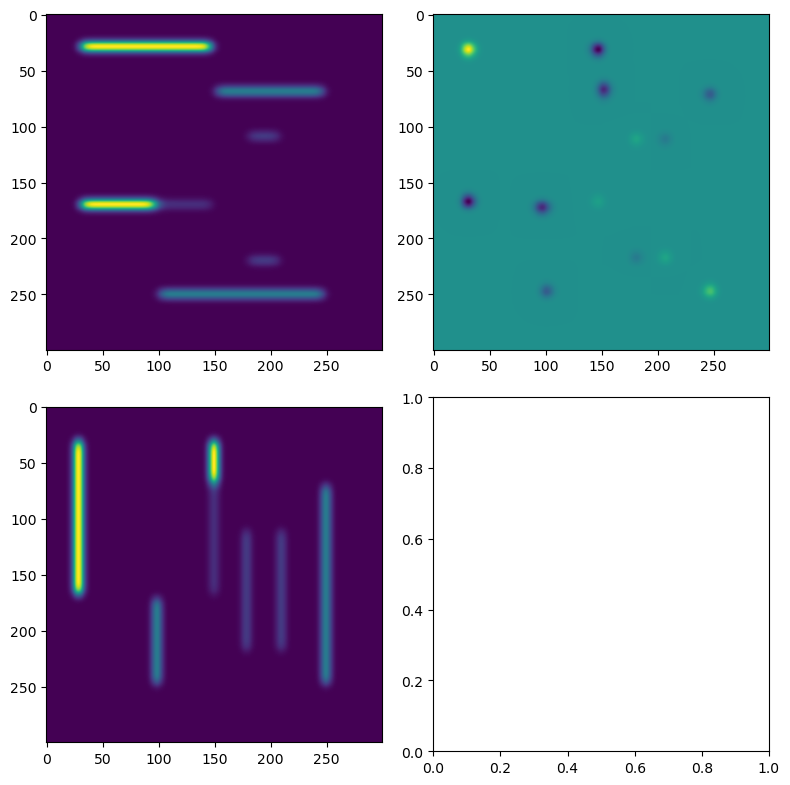

In [49]:
sigma = 5
epsilon = 1
C = smoothedHessian(im, sigma, epsilon)

fig, axs = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
axs = np.asarray(axs).ravel()
for ax, Ci in zip(axs, C):
    ax.imshow(Ci)

#### **Exercise 6.4** - *Create the `harrisMeasure()` function. What happens to $\texttt{r}$ if $\epsilon=0$? Why is it essential that $\epsilon \neq 0$?* 

$$\texttt{r}(x,y)=a\cdot b-c^2-\texttt{k}(a+b)^2$$

- Recall $k=0.06$ is a typical choice of $k$. Are there any large values near the corners?

Indeed, as seen by the bright green dots.

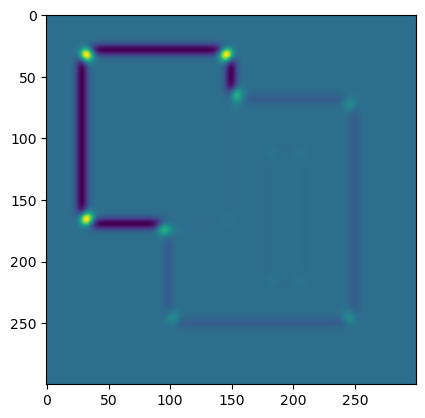

In [50]:
sigma = 4
epsilon = 4
k = 0.06

r = harrisMeasure(im, sigma, epsilon, k)
plt.imshow(r);

#### **Exercise 6.5** - *Create `cornerDetector()`, where $c$ is a list of points where $r$ is the local maximum and larger than some threshold $\tau$. Does it find all the corners in the image, or too many?*

It indeed finds a bit too many corners:

- If we adjust the $\tau$ threshold downwards our functions detects more of the corners, but if the value is too low it will also detect noise (or very small changes in intensity for x and y).
- If $\tau$ is increased it will only detect the 4 "brightest" corners with the largest changes in intensity

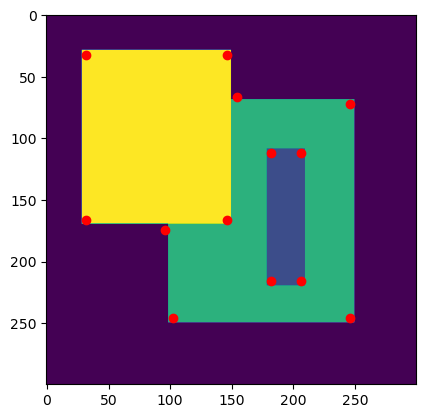

In [51]:
sigma = 4
epsilon = 4
k = 0.06
tau = .005

c = cornerDetector(im, sigma, epsilon, k, tau)

plt.imshow(im);
plt.scatter(*c, c='r');

### Canny edge detection (CDE)
#### **Exercise 6.6** - *Apply a Canny edge detector from cv2 on the test images.*

#### **Exercise 6.7** - *What is the effect of the threshold parameters in CDE?*
- If lower threshold is increased, edges are not detected in blurred parts (value of 150). However, decrease too much and it will detect blurring as edges (value of 5).

- If the upper threshold is increased too much (value 1000) it cannot detect any "anchor" points in the figure and will miss some of the figures completely.

- If both values are increased and set to be equal it will work as a normal thresholder and will only detect parts of the objects with the largest contrasts.


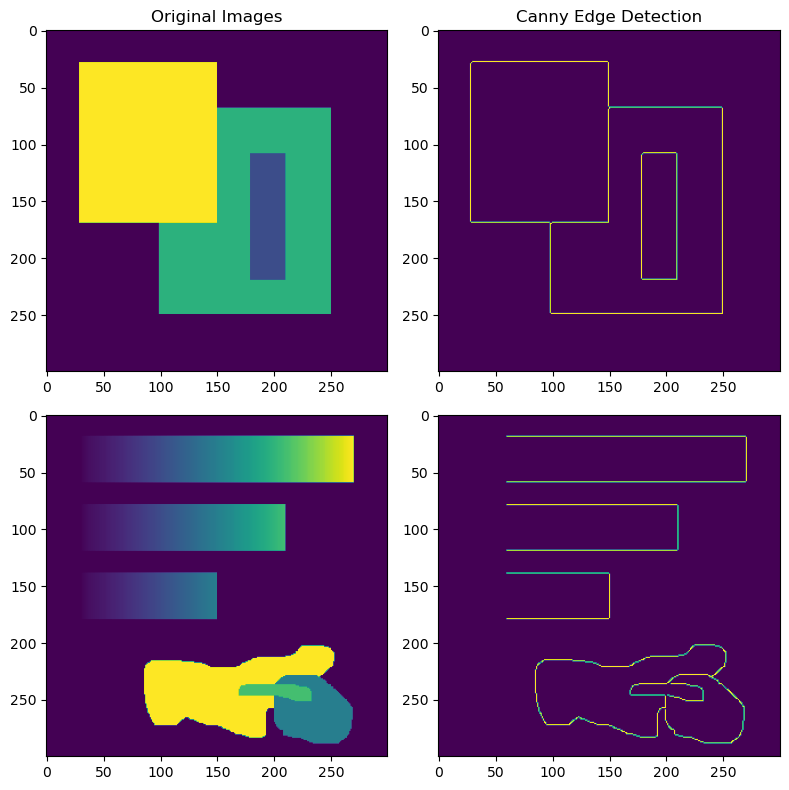

In [52]:
im1 = cv2.imread(f'data/TestIm1.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(f'data/TestIm2.png', cv2.IMREAD_GRAYSCALE)
edges1 = cv2.Canny(im1, im1.min(), im1.max())
edges2 = cv2.Canny(im2, 100, 200)
#Threshold 1 (100) is lower threshold (T2 in slides)
#Threshold 2 (200) is upper threshold (T1 in slides)
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(8, 8), tight_layout=True)
ax0.set_title('Original Images')
ax1.set_title('Canny Edge Detection')
ax0.imshow(im1)
ax2.imshow(im2)
ax1.imshow(edges1)
ax3.imshow(edges2);

# **Week 7** - *Robust model fitting*

Here we find straight lines using Hough transform, and impleent RANSAC algorithm to do the same for us.

Hough line notes:
- Isolate features of a particular shape within an image.
- Tolerant of gaps in feature boundary descriptions and is relatively unaffected by image noise.
- Used extensively in barcode scanning, verification and recognition

#### **Exercise 7.1** - *Load image and visualize the detected edges, e.g. by using Canny edge detection.*

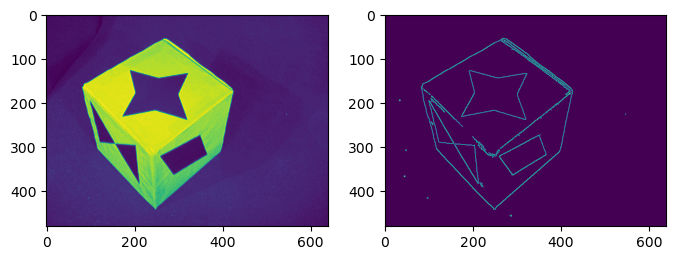

In [53]:
im = cv2.imread('data/Box3.bmp', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(im, 50, 150)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax0.imshow(im)
ax1.imshow(edges)

#### **Exercise 7.2+3+4** - *Compute Hough space from detected edges. What do the returned values mean? Identify the peaks in the Hough space.*


It simply returns an array of $(\rho,\theta)$ values. $\rho$ is measured in pixels and $\theta$ is measured in radians. First parameter, the input image should be a binary image, so apply threshold or use canny edge detection before applying hough transform. Second and third parameters are $\rho$ and $\theta$ accuracies respectively. Fourth argument is the threshold, which means the minimum vote it should get to be considered as a line. Remember, number of votes depends upon the number of points on the line. So it represents the minimum length of line that should be detected.
###### *From OpenCV documentation


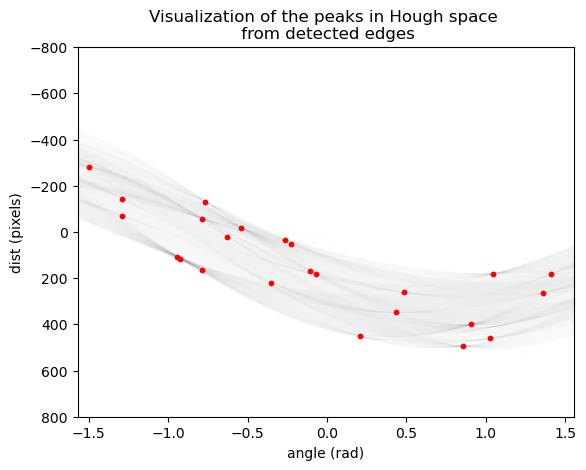

In [54]:
hspace, angles, dists = hough_line(edges)
#Hough space, angles (of lines) and length of lines (pixels) (?)
extent = [angles[0], angles[-1], dists[-1], dists[0]]

n = 100
extH, extAngles, extDists = hough_line_peaks(hspace, angles, dists, threshold=0.3 * hspace.max(), num_peaks=n)

fig, ax = plt.subplots()
ax.imshow(hspace, cmap='gray_r', extent=extent, aspect='auto')
ax.scatter(extAngles, extDists, c='r', s=10)
ax.set_title('Visualization of the peaks in Hough space \n from detected edges')
ax.set_xlabel('angle (rad)')
ax.set_ylabel('dist (pixels)');
# Note that knots/peaks are highly probable true lines (?)

#### **Exercise 7.5** - *Draw lines on original image corresponding to identified peaks*

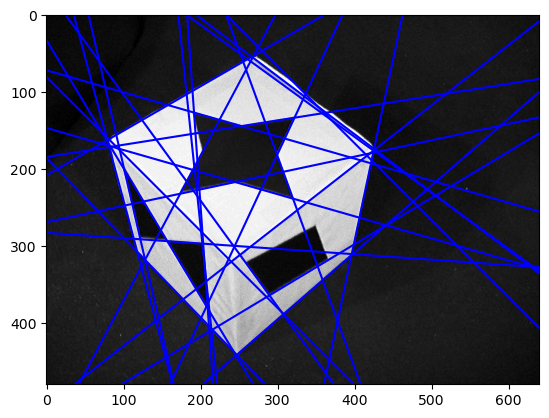

In [55]:
lines = np.vstack((np.cos(extAngles), np.sin(extAngles), -extDists))

fig, ax = plt.subplots()

ax.imshow(im, cmap='gray')
for l in lines.T:
    DrawLine(l, im.shape, ax=ax)

#### **RANSAC**

#### **Exercise 7.6 (7.9)** - *Make a function that estimates a line, in homogeneous coordinates, given two points.*

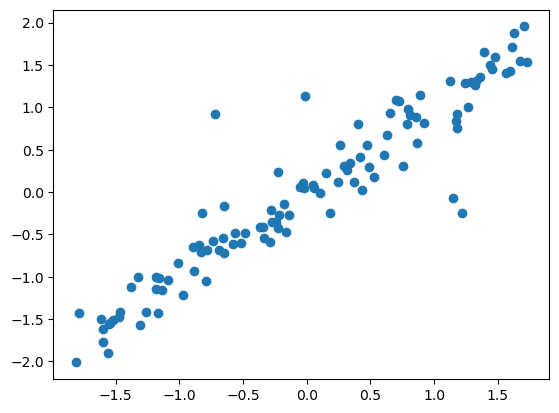

In [57]:
# Generate some points with inliers and some outliers.
def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5+np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

n_in, n_out = 100, 10
points = test_points(n_in, n_out)
points = (points - points.mean(1)[:, np.newaxis]) / points.std(1)[:, np.newaxis]

plt.scatter(*points);

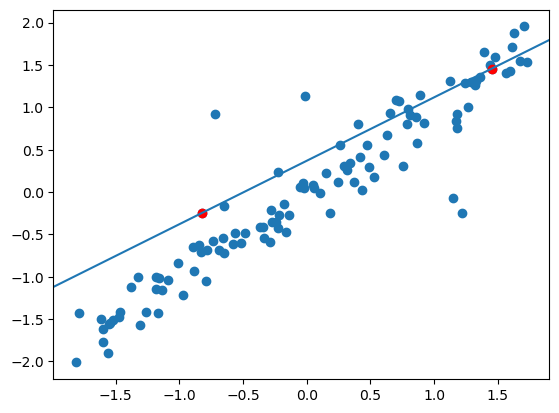

In [58]:
# Take two random points and draw a line between them.
draw_random = lambda points: points[:, np.random.choice(points.shape[1], size=2, replace=False)].T
p1, p2 = draw_random(points)
p1, p2 = p1[:, np.newaxis], p2[:, np.newaxis]
l = lines_from_points(p1, p2)
a, b, c = l

fig, ax = plt.subplots()
ax.scatter(*points)
ax.scatter(*p1, c='r')
ax.scatter(*p2, c='r')
x0, x1 = ax.get_xlim()
ax.plot((x0, x1), (-(x0 * a + c) / b, -(x1 * a + c)/b))
ax.set_xlim(x0, x1);

#### **Exercise 7.7+8** - *Make function that determines which points from a set of 2D points are inliers and outliers wrt. a given line. Include a threshold parameter $\tau$ for later use. Do the same for number of inliers, for a line wrt. a set of points*

In [59]:
inliers = line_inliers(l[:, 0], points, tau=.25)
inliers.sum()

102

#### **Exercise 7.10+11+12+13** - *Implement `RANSAC`*

- What is a good threshold for distinguishing between inliers and outliers?

$\tau=0.1$ seemed to work pretty good.

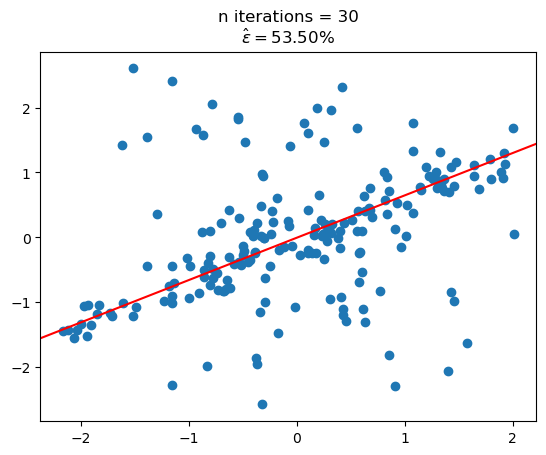

In [61]:
def pca_line(x): #assumes x is a (2 x n) array of points
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(l@x.mean(1)))
    return l

n_in, n_out = 100, 100
tau = .1
p = 0.999

points = test_points(n_in, n_out)
points = (points - points.mean(1)[:, np.newaxis]) / points.std(1)[:, np.newaxis]

n = 2 # We need 2 points to fit a line
m = points.shape[1]
s_best = 0
l_best = None
i = 0
done = False
while not done:
    p1, p2 = draw_random(points)
    p1, p2 = p1[:, np.newaxis], p2[:, np.newaxis]
    l = lines_from_points(p1, p2)
    s = line_inliers(l[:, 0], points, tau).sum()
    if s > s_best:
        s_best = s
        l_best = l
        epsilon = 1 - s_best/m
        N_upper = np.log(1-p) / np.log(1-(1-epsilon)**n)
    if i > N_upper:
        done = True
    i += 1

inliers = line_inliers(l_best[:, 0], points, tau)
l_inlier_fit = pca_line(points[:, inliers])
a, b, c = l_inlier_fit

fig, ax = plt.subplots()
ax.scatter(*points)
x0, x1 = ax.get_xlim()
ax.plot((x0, x1), (-(x0 * a + c) / b, -(x1 * a + c)/b), c='r')
ax.set_xlim(x0, x1)
ax.set_title(f'n iterations = {i}\n' + r'$\hat\varepsilon = $' + f'{epsilon:.2%}');

# **Week 8** - *BLOBs and SIFT features*

We will write code for a blob detector as well as use the SIFT feature detector and matcher. We will use the Difference-of-Gaussians method (DoG) for BLOB detection.

Note that he size of the circle should correspond to the size of the blob. The magnitude of the blob response only says something about how strong the blob signal is,  but nothing about the size of the blob itself.

# Week 13 - Structured Light / 3D scanning

#### **Exercise 13.1** - *Uncalibrated cameras need calibration. How would you find their intrinsics and extrinsics?*

- If not calibrated, use checkerboards to compute the essential and/or fundamental matrix!

- The camera *intrinsic* matrix $K\in\mathbb{R}^{3\times 3}$ is uppter triangular and defined as:
$$K=\begin{bmatrix}f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1\end{bmatrix},$$
where $f_x$ and $f_y$ are the sensor's focal lengths in unit of pixels. $s$ is any possible skew between sensor axes. Usually $s=0$, unless misalignment of sensor and optical axis. $c_x$ and $c_y$ denote optical center in pixel coordinates, in unit of pixels.
- Extrincics come from the camera *extrinsic* matrix $[R|t]\in\mathbb{R}^{3\times 4}$ defined as:
$$[R|t]=\begin{bmatrix}R_{1,1} & R_{1,2} & R_{1,3} & t_0 \\ R_{2,1} & R_{2,2} & R_{2,3} & t_1 \\ R_{3,1} & R_{3,2} & R_{3,3} & t_2\end{bmatrix},$$


#### **Exercise 13.2** - *Rectifying images.*

In [56]:
im0 = cv2.imread(os.path.join(casper_path, "sequence/frames0_0.png"))
size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],
                           c['d1'], size, c['R'], c['t'], flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)




ims0 = []
ims1 = []

images = sorted_alphanumeric(os.listdir(os.path.join(casper_path, 'sequence')))
for i in images:
    #print(i)
    im = cv2.imread(os.path.join(casper_path, f'sequence/{i}'), cv2.IMREAD_GRAYSCALE).astype(np.float64)
    size = (im.shape[1], im.shape[0])
    stereo = cv2.stereoRectify(c['K0'], c['d0'], c['K1'],c['d1'], size, c['R'], c['t'], flags=0)
    R0, R1, P0, P1 = stereo[:4]
    maps0 = cv2.initUndistortRectifyMap(c['K0'], c['d0'], R0, P0, size, cv2.CV_32FC2)
    maps1 = cv2.initUndistortRectifyMap(c['K1'], c['d1'], R1, P1, size, cv2.CV_32FC2)

    if 'frames0' in i:
        img = cv2.remap(im, *maps0, cv2.INTER_LINEAR)
        ims0.append(img)
    else:
        img = cv2.remap(im, *maps1, cv2.INTER_LINEAR)
        ims1.append(img)


fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].imshow(ims0[0], cmap='gray')
ax[1].imshow(ims1[0], cmap='gray')
    

NameError: name 'casper_path' is not defined

#### **Exercise 13.3** - *Compute phases of images*

In [ ]:
def unwrap(ims, n1):
    # A list of 16 images
    primary_images = ims[2:18]
    secondary_images = ims[18:26]
    # Fast fourier transforms brrrrt
    fft_primary = np.fft.rfft(primary_images, axis=0) # use rfft as input is only real numbers
    fft_secondary = np.fft.rfft(secondary_images, axis=0) 

    # The Fourier component corresponding to the pattern is in the second component
    theta_primary = np.angle(fft_primary[1])
    theta_secondary = np.angle(fft_secondary[1])

    theta_c = (theta_secondary - theta_primary) % (2*np.pi)

    o_primary = np.round((n1 * theta_c - theta_primary) / (2*np.pi))

    theta = ((2*np.pi * o_primary + theta_primary) / n1) % (2*np.pi)

    return theta
# Phases for camera 0 and 1.
theta0 = unwrap(ims0, n1=40)
theta1 = unwrap(ims1, n1=41)
plt.imshow(theta0)

#### **Exercise 13.4** - *Highlight parts of phase image, which are sufficiently illuminated by the projector. Apply threshold of 15 when getting mask for each camera*

In [ ]:
# Subtract the fully on and fully off
# projector image from each other (initial two elements of ims) 
# to obtain a measurement of how
# much projector light is in each pixel.
projector_light0 = ims0[0]-ims0[1]
projector_light1 = ims1[0]-ims1[1]

mask0 = (projector_light0 > 15)
mask1 = (projector_light1 > 15)

plt.imshow(mask0)

#### **Exercise 13.5** - *Find (pixel) matches between cameras*

In [ ]:
q0s = []
q1s = []
im0 = ims0[0]
im1 = ims1[0]
pixels0 = np.zeros((ims0[0].shape))

for i in range(im0.shape[0]):
    for j in range(im0.shape[1]):
        if mask0[i,j] == True:
            epipolar_line = im1[i,:]
            # find j index that minimises distance between thetas
            j1 = np.argmin([abs(theta1[i,j1]-theta0[i,j]) if mask1[i,j1] else np.inf for j1 in range(len(epipolar_line))])
            
            q0s.append((i,j))
            q1s.append((i,j1))
            
disparity = np.zeros((im0.shape))

for k, (i0,j0) in enumerate(q0s):
    i1, j1 = q1s[k]
    disparity[i0, j0] = j0-j1
#Median filtering suppresses small errors throwing colour map off.
disparity = cv2.medianBlur(disparity.astype(np.float32), 5)
plt.imshow(disparity)